/var/folders/q7/smgpmbmj4x55d0j109bpfrgw0000gn/T/ipykernel_61061/3514044064.py:39: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(7, 7))


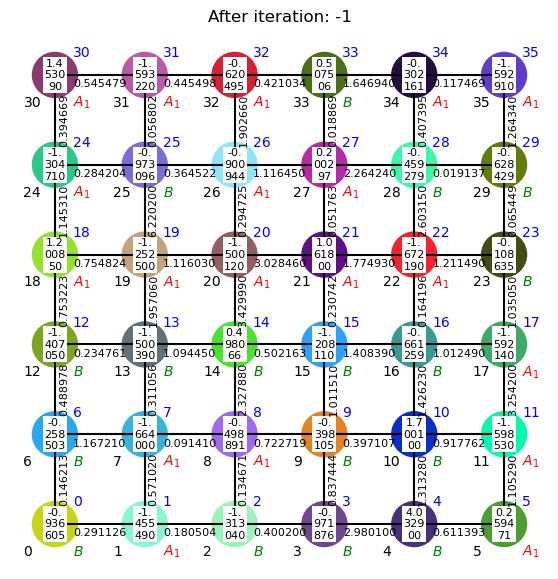

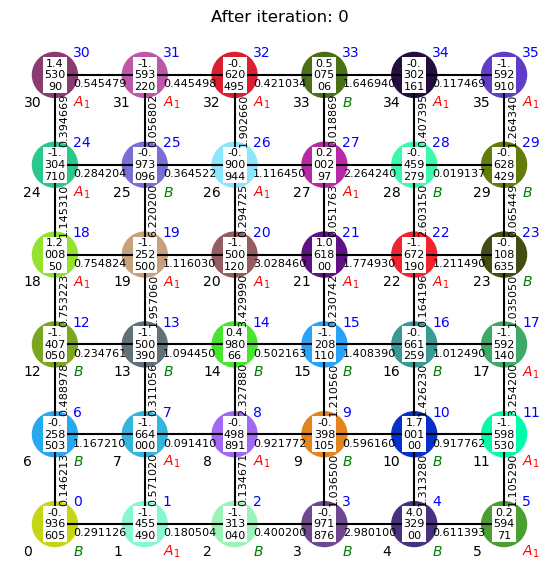

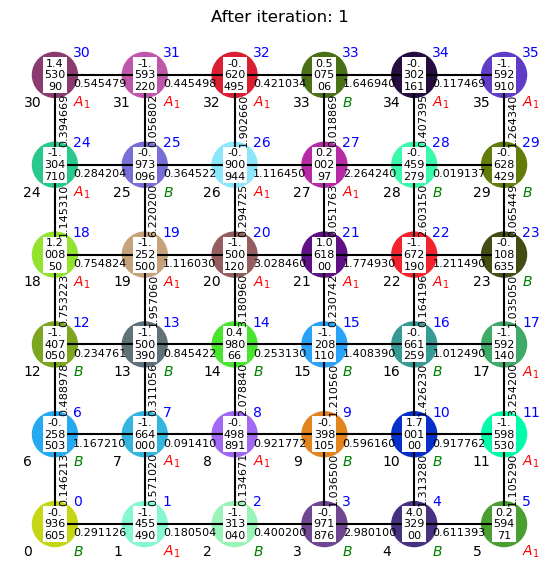

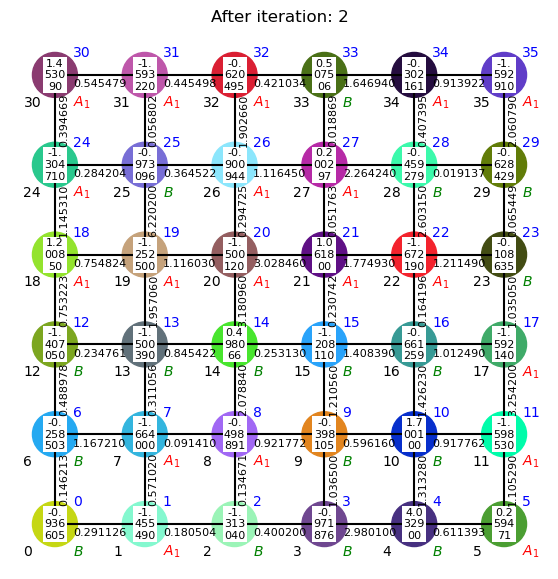

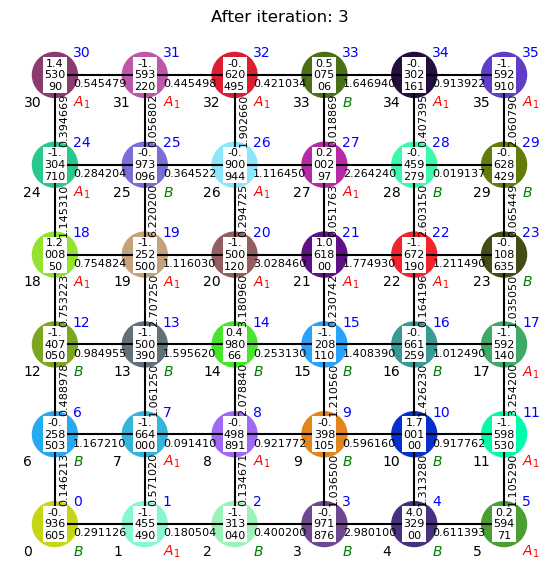

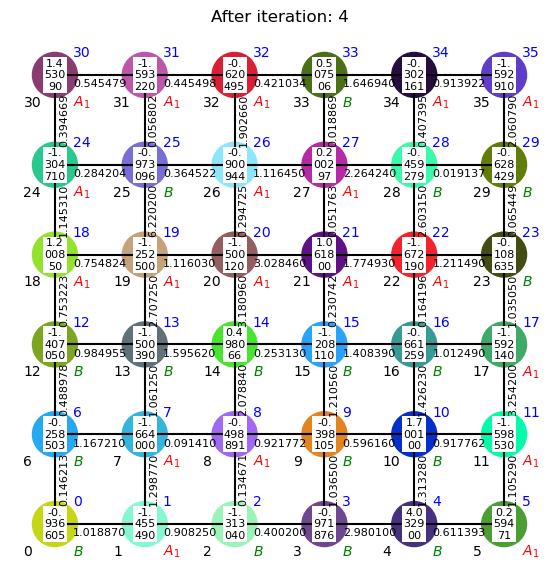

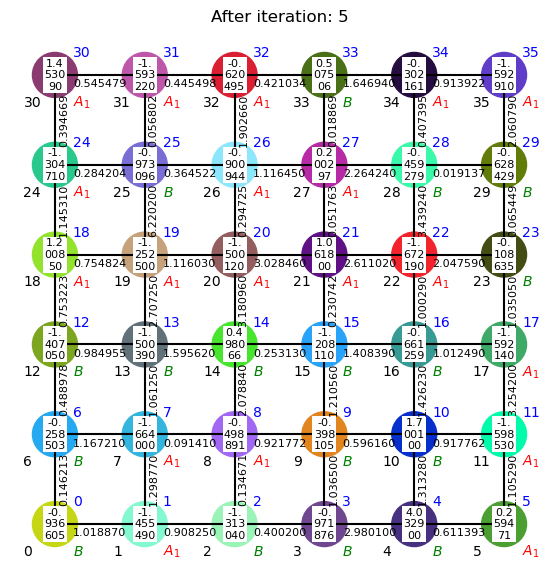

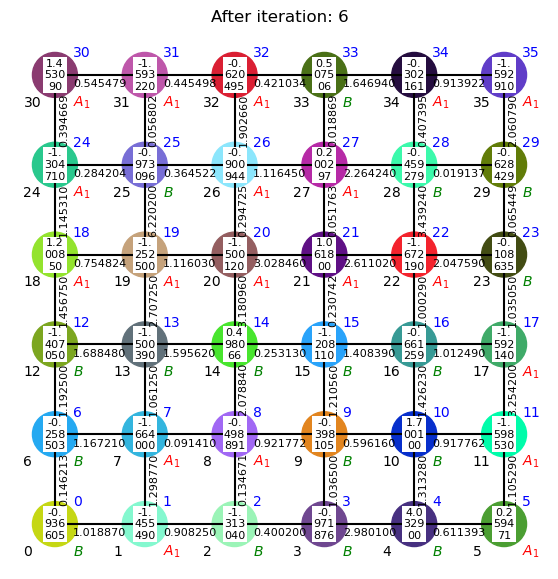

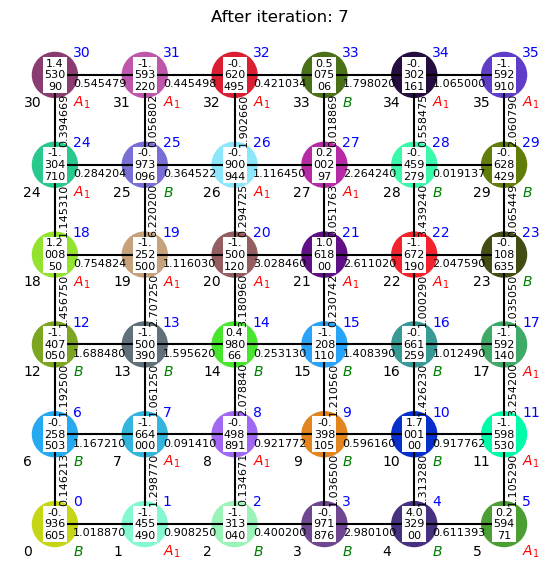

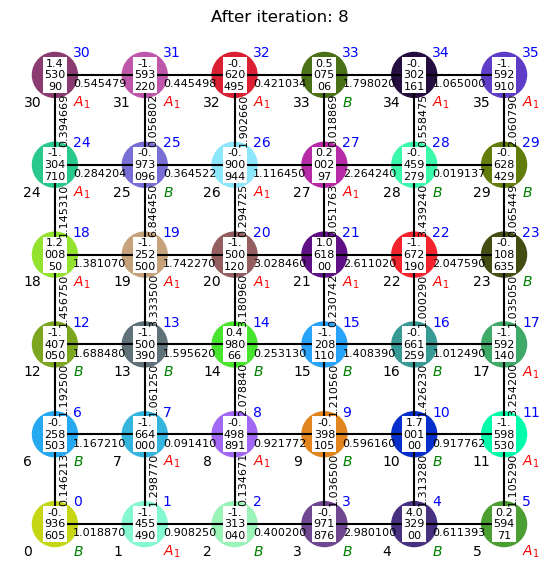

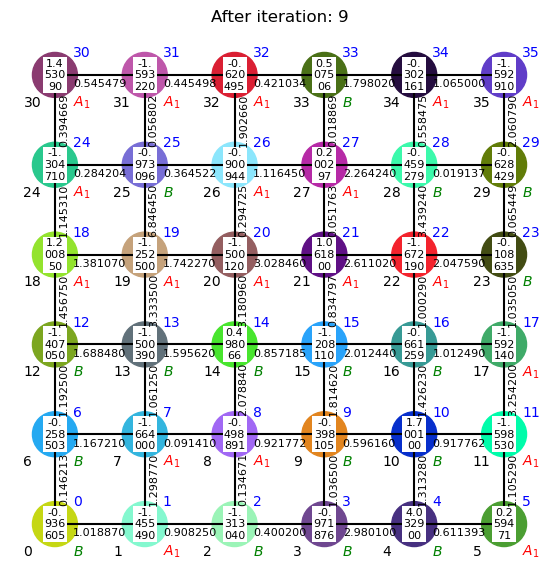

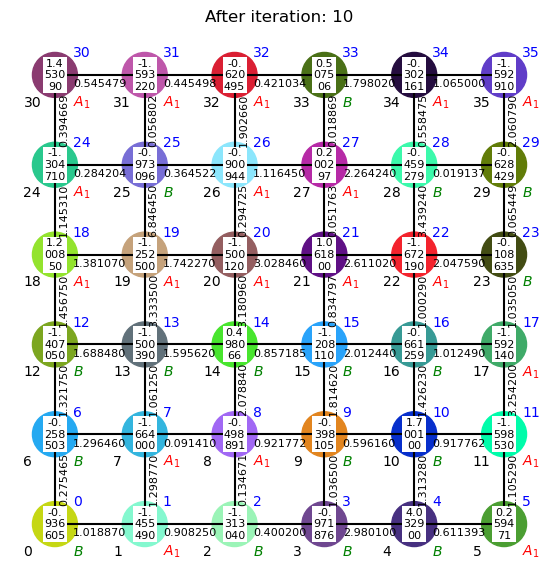

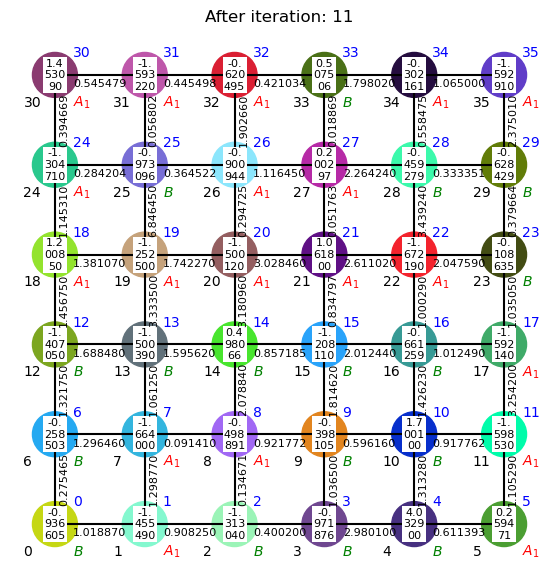

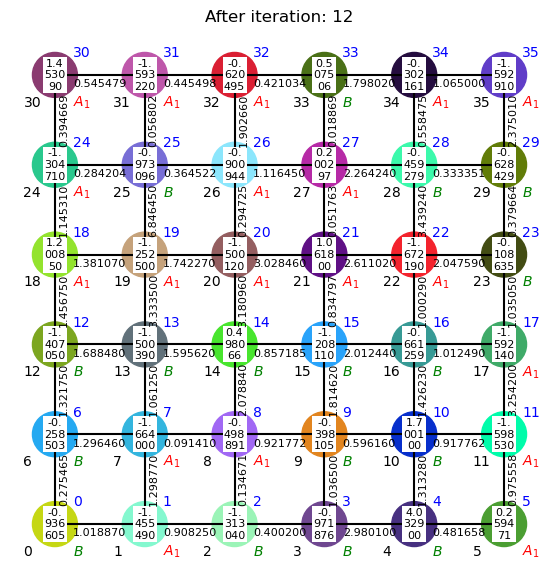

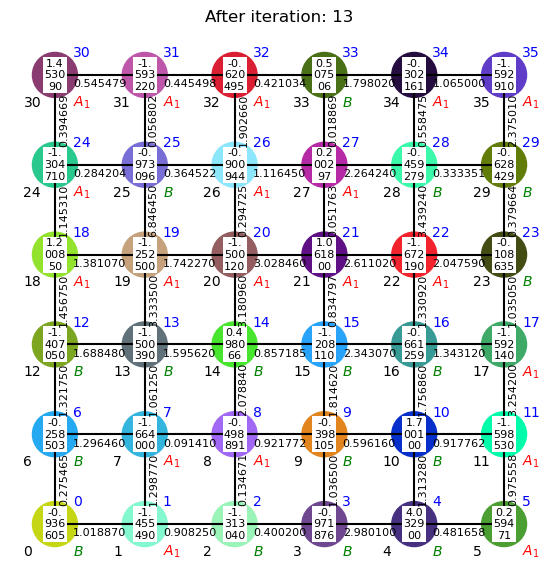

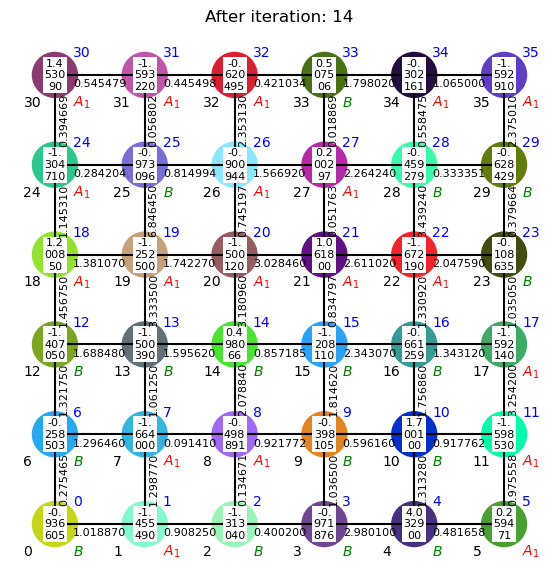

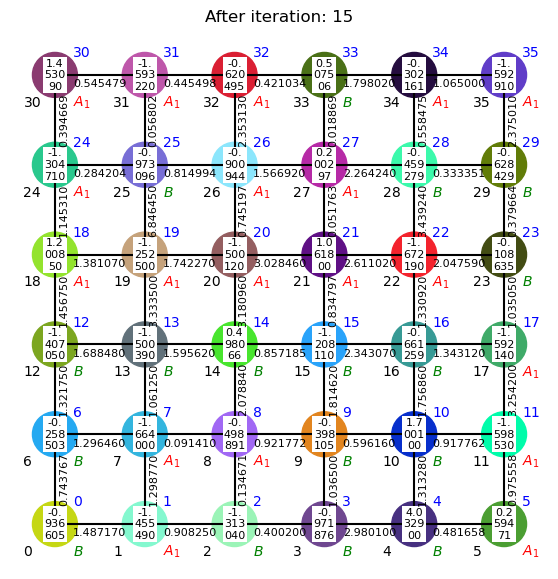

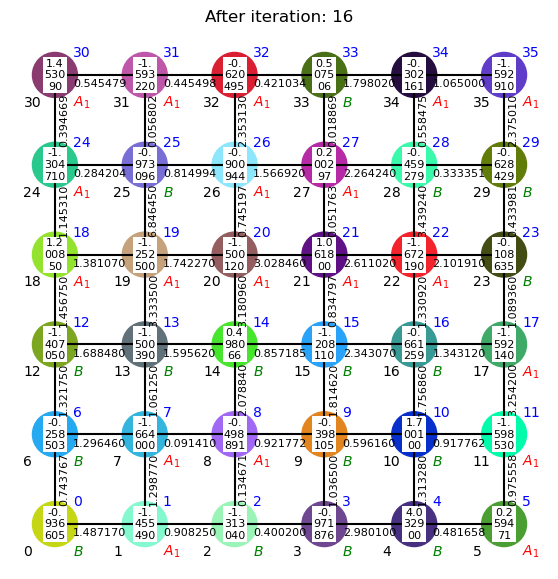

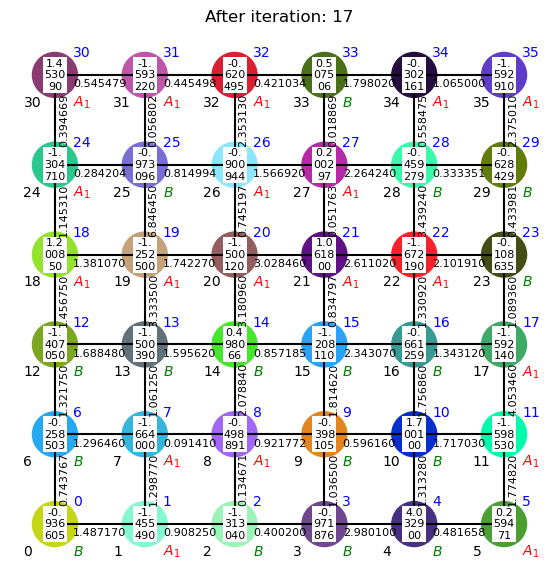

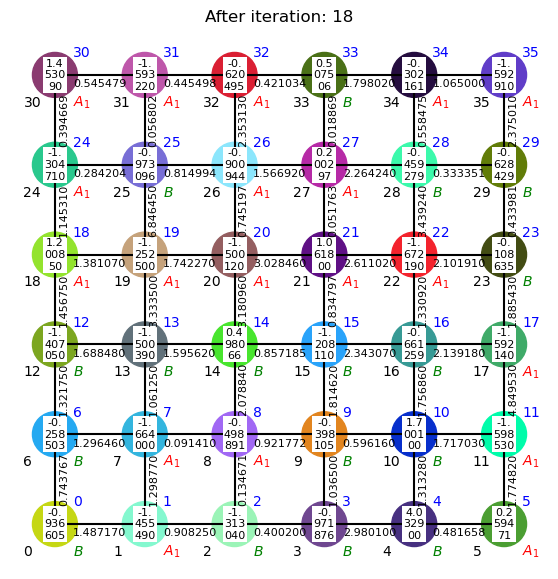

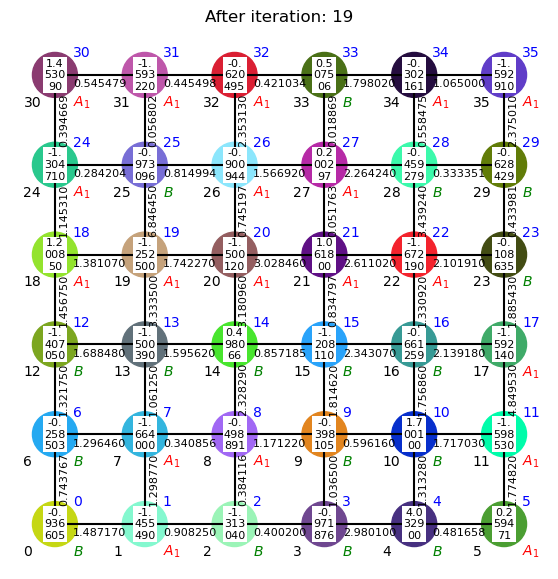

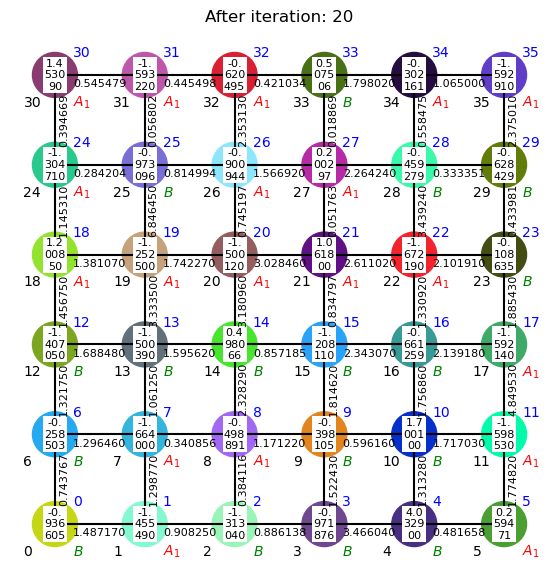

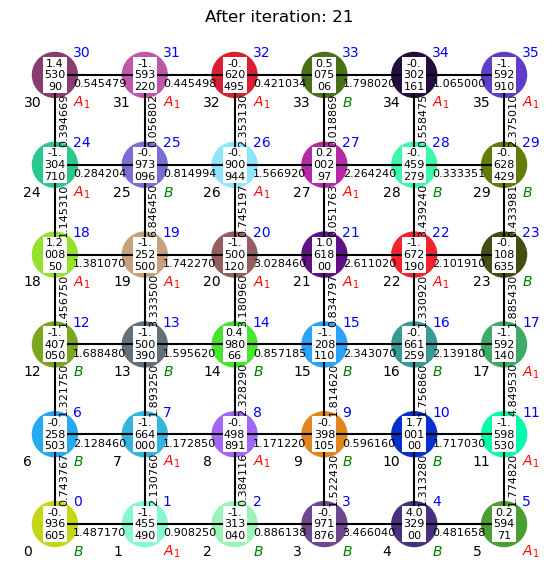

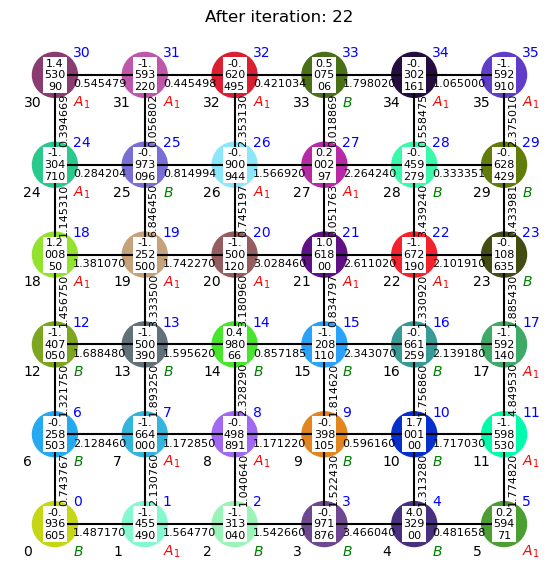

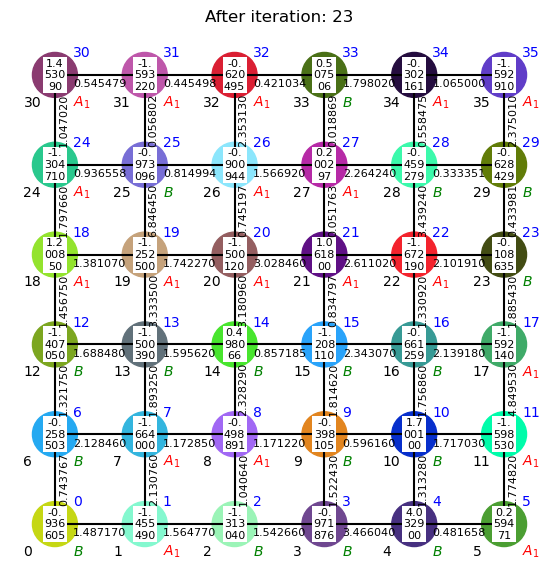

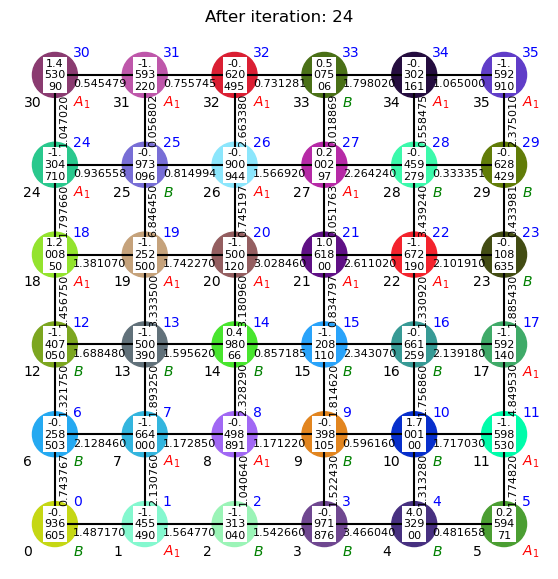

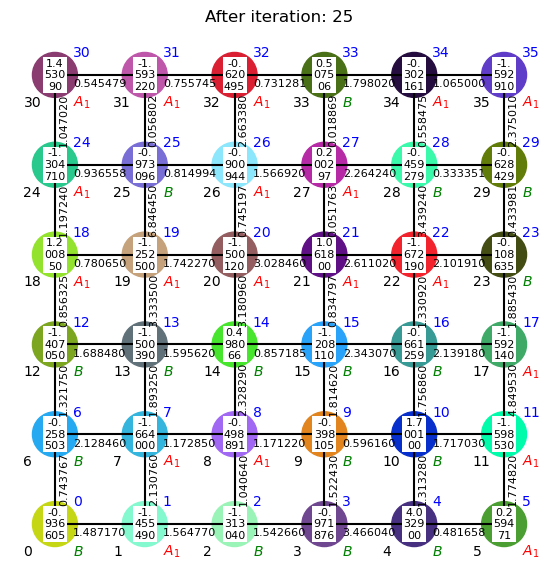

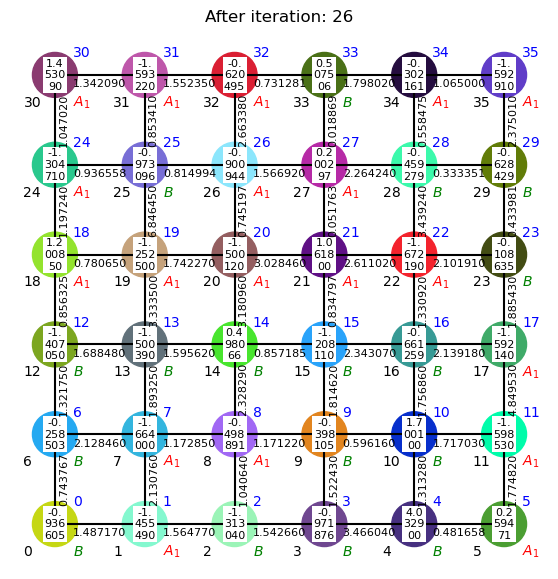

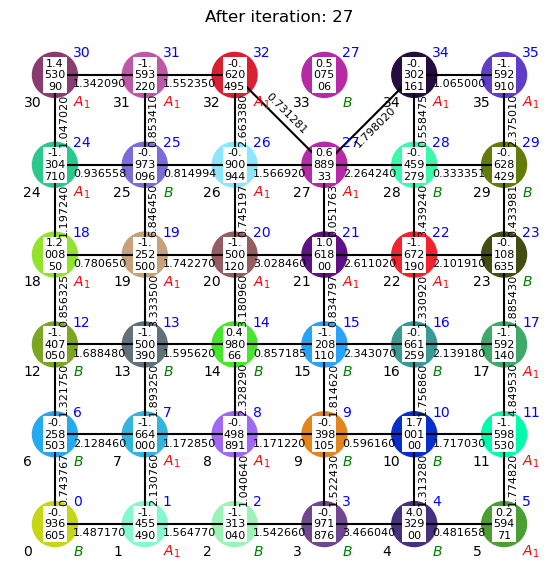

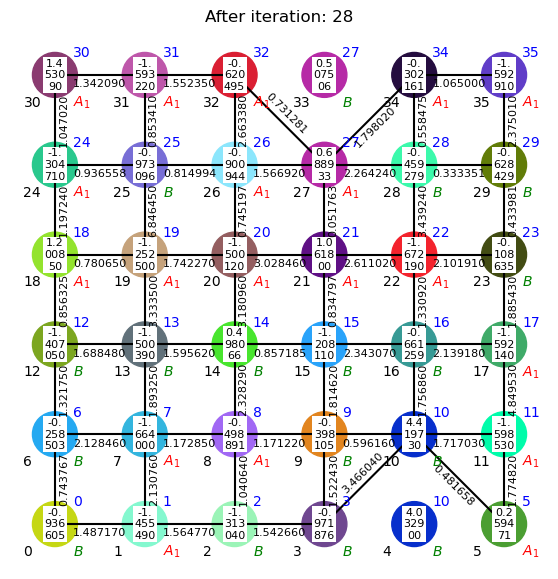

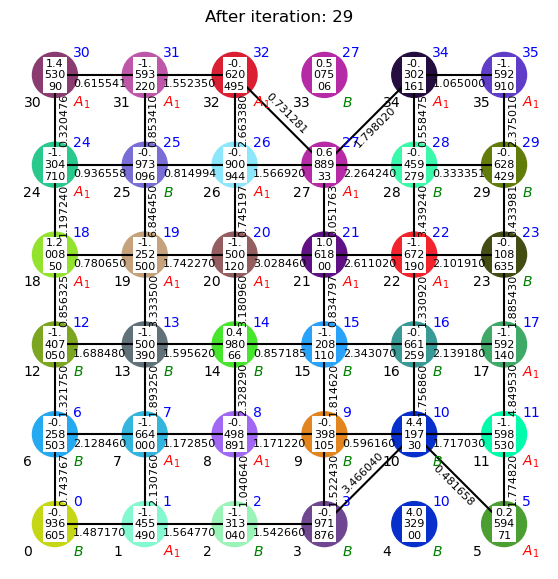

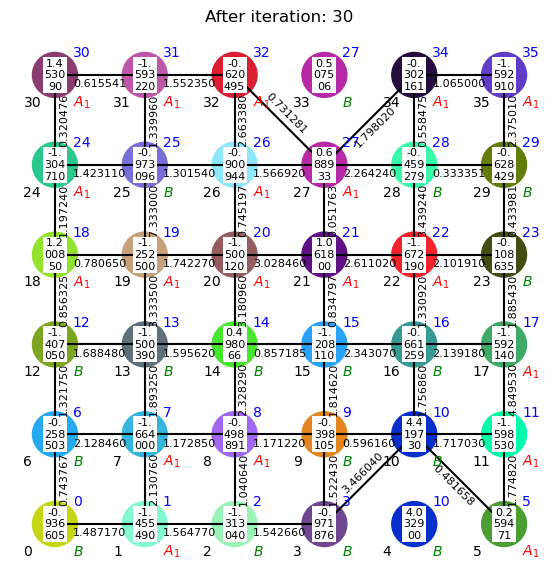

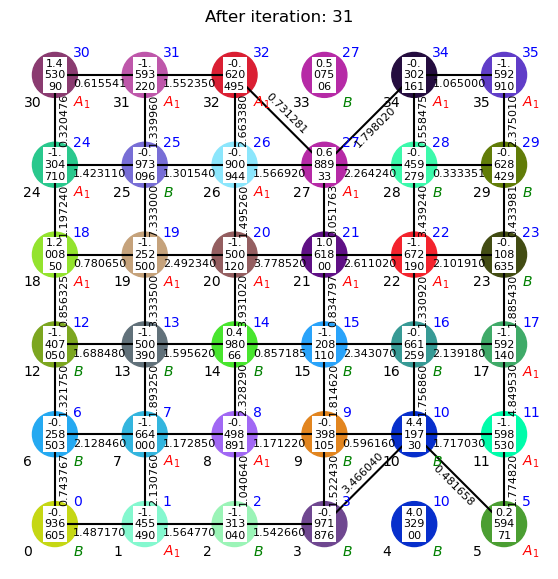

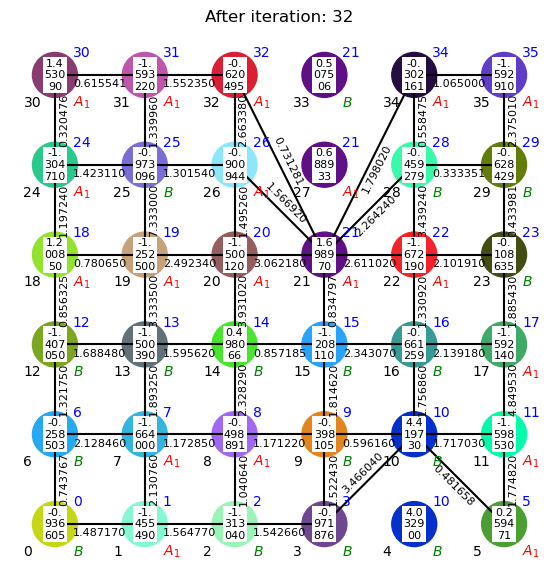

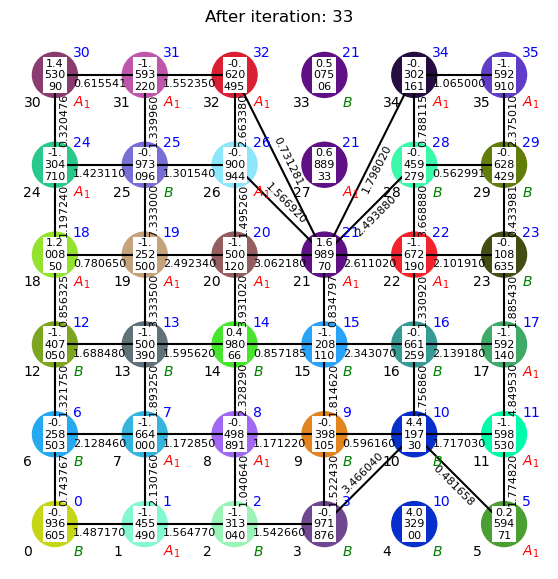

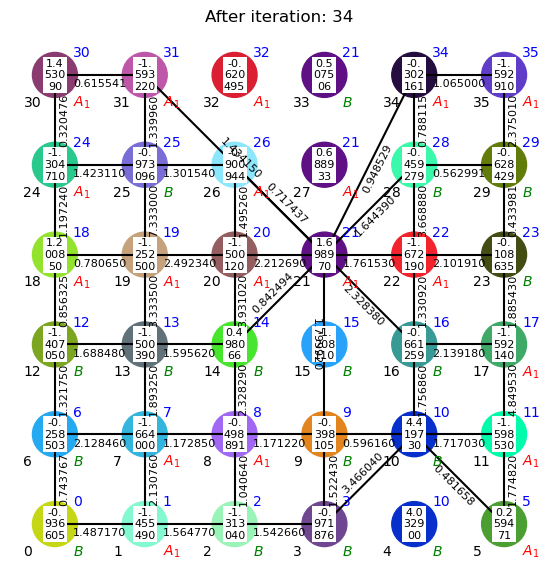

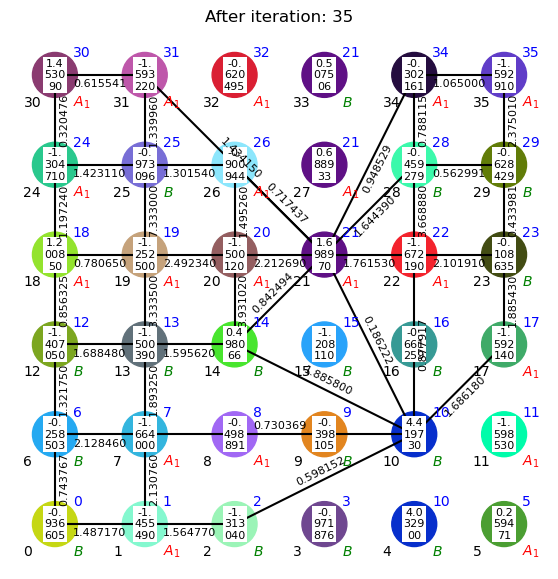

In [1]:
######################################
#  An efficient SDRG implementation. #
#  Copyright (C) 2023  Geet Rakala   #
#  GNU GPLv3. See /LICENSE.txt       #
######################################
import json
import glob
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import random
import math
from math import atan2, degrees, cos, sin, pi

def color_distance(color1, color2):
    r1, g1, b1 = color1
    r2, g2, b2 = color2
    return math.sqrt((r1 - r2)**2 + (g1 - g2)**2 + (b1 - b2)**2)

def get_unique_random_color(existing_colors, min_distance=10):
    random.seed(0)
    while True:
        r, g, b = random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)
        
        # Check if the color is not too close to white
        if r + g + b >= 650:
            continue
        
        is_unique = True
        for color in existing_colors:
            if color_distance(color, (r, g, b)) < min_distance:
                is_unique = False
                break
        
        if is_unique:
            return "#{:02x}{:02x}{:02x}".format(r, g, b), (r, g, b)

def plot_square_lattice(data,iteration_number,output_file,cluster_color_map):
    fig, ax = plt.subplots(figsize=(7, 7))
    
    # Extract x and y coordinates from the node data
    x_coords = [node['x'] for node in data['nodes']]
    y_coords = [node['y'] for node in data['nodes']]
    
    # Calculate axis bounds based on min and max coordinates with some padding
    padding = 0.5
    x_min = min(x_coords) - padding
    x_max = max(x_coords) + padding
    y_min = min(y_coords) - padding
    y_max = max(y_coords) + padding
    
    # Set axis bounds
    ax.set_xlim([x_min, x_max])
    ax.set_ylim([y_min, y_max])

    existing_colors = [color[1] for color in cluster_color_map.values()]
    # Plot nodes
    for index, node in enumerate(data['nodes']):
        
        cluster_index = node['clusterIndex']
        
        # If the cluster index is not in the color map, add it
        if cluster_index not in cluster_color_map:
            new_color, rgb_tuple = get_unique_random_color(existing_colors)
            cluster_color_map[cluster_index] = (new_color, rgb_tuple)
            existing_colors.append(rgb_tuple)
        
        x, y = node['x'], node['y']
        color = cluster_color_map[cluster_index][0]
        circle = plt.Circle((x, y), 0.25, color=color)
        ax.add_patch(circle)
        
        # Breaking range text into multiple lines
        range_text = "{:.6f}".format(node['range'])
        lines = [range_text[i:i + 3] for i in range(0, len(range_text), 3)]
        multi_line_text = "\n".join(lines)
        
        # Add background color to the range text
        ax.text(x, y, multi_line_text, ha='center', va='center', fontsize=8,
                bbox=dict(facecolor='white', edgecolor='none', pad=1))
        
        # Add node number text
        ax.text(x-0.35, y-0.35, str(index), fontsize=10)

        # Add cluster index text
        ax.text(x+0.2, y+0.2, str(node['clusterIndex']), fontsize=10, color='blue')
       
        # Add subSystem text
        if node['subsystem'] == 0:
            subsystem_text = f'$B$'
            text_color = 'green'
        else:
            subsystem_text = f'$A_{{ {node["subsystem"]} }}$'
            text_color = 'red'
        ax.text(x + 0.2, y - 0.35, subsystem_text, fontsize=10, color=text_color)
        
    # Plot edges
    for edge in data['edges']:
        x1, y1 = data['nodes'][edge['from']]['x'], data['nodes'][edge['from']]['y']
        x2, y2 = data['nodes'][edge['to']]['x'], data['nodes'][edge['to']]['y']
        ax.plot([x1, x2], [y1, y2], 'k-')
        mx, my = (x1 + x2) / 2, (y1 + y2) / 2
        # Calculate the angle in radians
        angle_rad = atan2(y2 - y1, x2 - x1)
    
        # Convert the angle to degrees
        angle_deg = degrees(angle_rad)
        
        # Adjust angle if it's in the 2nd or 3rd quadrant
        if 90 < angle_deg <= 180:
            angle_deg -= 180
        elif -180 <= angle_deg < -90:
            angle_deg += 180
        # Calculate offsets for text based on angle (making them perpendicular)
        offset = 0.1  # 0.1 is the distance of the text from the midpoint of the edge
        offset_x = offset * sin(angle_rad)
        offset_y = offset * -cos(angle_rad)

        ax.text(mx + offset_x, my + offset_y, "{:.6f}".format(edge['distance']),
                ha='center', va='center', fontsize=8, rotation=angle_deg)
    ax.set_title("After iteration: {}".format(iteration_number))
    ax.set_aspect(1.0)
    ax.axis('off')
    #plt.savefig(output_file, format='pdf')
    #plt.close()

# Initialize cluster_color_map outside the function
# Initialize with a special white color for -1
cluster_color_map = {-1: ('white', (255, 255, 255))}  

# Path to the json folder
json_folder = 'json/'

# Use glob to find all json files matching the pattern
json_files = glob.glob(json_folder + 'graph_data_*.json')

# Sort the json files by extracting the integer i from the filename
json_files.sort(key=lambda x: int(x.split('_')[-1].split('.')[0]))

# Iterate through the sorted json files
for json_file in json_files:
    with open(json_file) as file:
        data = json.load(file)

    # Extract the iteration number from the filename
    iteration_number = int(json_file.split('_')[-1].split('.')[0]) - 2 

    # Generate the PDF filename with the current iteration number
    pdf_filename = 'pdf/square_lattice_' + str(iteration_number) + '.pdf'

    # Call the function
    plot_square_lattice(data,iteration_number,pdf_filename,cluster_color_map)